# Common Neighbor Rule in PyC Subgraph (Th=100)

In [1]:
import os
import random
from time import time
import pandas as pd
import numpy as np
import networkx as nx

from utils.utils import *
from utils.proximity import *
from utils.graph_creation import *
from utils.visualization import *
from utils.common_neighbor_rule import *

### 1. Create PyC Subgraph and Load Proximity Model

In [2]:
pyc_synapses = pd.read_csv('data/synapses.csv')
pyc_soma = pd.read_csv('data/soma.csv')

In [3]:
# create the simple directed graph (no self-loops, no multi-edges)
# treat multiple synapses as one connection
pyc_subgraph = synapses_to_connections(pyc_synapses[['pre','post']])
# remove self-loops
g_actual = remove_autapses(edges_to_graph(pyc_subgraph))
g_actual.add_nodes_from(pyc_soma["segment_id"])

In [4]:
locs = {n:string2array(np.array(pyc_soma[pyc_soma["segment_id"] == n]["loc"])[0]) for n in g_actual.nodes()}
axls = {n:np.array(pyc_soma[pyc_soma["segment_id"] == n]["axon_len"])[0] for n in g_actual.nodes()}
nx.set_node_attributes(g_actual, locs, "loc")
nx.set_node_attributes(g_actual, axls, "axl")

In [5]:
g_th100 = get_thresholded_graph(g_actual, axls, 100)
print(nx.info(g_th100))

Name: 
Type: DiGraph
Number of nodes: 111
Number of edges: 659
Average in degree:   5.9369
Average out degree:   5.9369


In [6]:
# load precomputed proximity data and plot
prox_th100 = pd.read_csv('saved/proximity_th100_avg10um.csv')

### 2. Compare 2-Cell Motif Statistics (OBS vs ER vs PM)

In [7]:
%%time
# calculate common neighbor stats in the observation
obs_cnr_stats = get_cnr_stats(g_th100)

CPU times: user 268 ms, sys: 8 ms, total: 276 ms
Wall time: 271 ms


- "undir_pair" - number of pairs with [bin] common neighbor
- "dir_spair" - number of pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_ppair" - number of pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_conn" - number of connected pairs with [bin] common neighbor
- "dir_sconn" - number of connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_pconn" - number of connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_uni_sconn" - number of unidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_uni_pconn" - number of unidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "dir_bi_sconn" - number of bidirectionally connected pairs with [bin] common successor (strict, not a predecessor to any)
- "dir_bi_pconn" - number of bidirectionally connected pairs with [bin] common predecessor (strict, not a successor to any)
- "undir_perc" - percentage of pairs with [bin] common neighbor to be connected
- "dir_sperc" - percentage of pairs with [bin] strict common successor to be connected
- "dir_pperc" - percentage of pairs with [bin] strict common predcessor to be connected

In [8]:
obs_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,2027.0,4676.0,3927.0,101.0,400.0,351.0,378.0,334.0,22.0,17.0,0.049827,0.085543,0.089381
1,1741.0,1031.0,1593.0,164.0,140.0,197.0,134.0,188.0,6.0,9.0,0.094199,0.135790,0.123666
2,1106.0,271.0,460.0,135.0,52.0,61.0,51.0,59.0,1.0,2.0,0.122061,0.191882,0.132609
3,637.0,85.0,106.0,102.0,20.0,19.0,20.0,18.0,0.0,1.0,0.160126,0.235294,0.179245
4,314.0,22.0,17.0,53.0,10.0,2.0,10.0,2.0,0.0,0.0,0.168790,0.454545,0.117647
5,145.0,14.0,2.0,31.0,5.0,0.0,5.0,0.0,0.0,0.0,0.213793,0.357143,0.000000
6,76.0,5.0,0.0,17.0,3.0,0.0,3.0,0.0,0.0,0.0,0.223684,0.600000,0.000000
7,27.0,0.0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.407407,0.000000,0.000000
8,19.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.526316,0.000000,0.000000
9,13.0,1.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.461538,0.000000,0.000000


In [10]:
%%time
# sample graphs from proximity model and compute CNR stats
s=100 # total 100 samples (100 continous samples)
pm_cnr_samples = proximity_sample_cnr(g_th100, samples=s, 
                                      ps=prox_th100["p_connect"], 
                                      edge_order=prox_th100["edge_order"])
pm_cnr_stats, pm_cnr_stats_std = cnr_mean_std(pm_cnr_samples)


CPU times: user 18.7 s, sys: 40 ms, total: 18.8 s
Wall time: 19.3 s


In [13]:
# save sampled CNR stats from proximity model as intermediate data
pm_cnr_stats.to_csv("saved/th100_cnr_pm100.csv", index=False)
pm_cnr_stats_std.to_csv("saved/th100_cnrstd_pm100.csv", index=False)

In [14]:
# load precomputed CNR stats counts from CFG model
pm_cnr_stats = pd.read_csv("saved/th100_cnr_pm100.csv")
pm_cnr_stats_std = pd.read_csv("saved/th100_cnrstd_pm100.csv")

In [15]:
pm_cnr_stats

,undir_pair,dir_spair,dir_ppair,undir_conn,dir_sconn,dir_pconn,dir_uni_sconn,dir_uni_pconn,dir_bi_sconn,dir_bi_pconn,undir_perc,dir_sperc,dir_pperc
0,1849.92,4512.30,4517.52,178.76,464.47,464.37,449.38,448.97,15.09,15.40,0.096859,0.103024,0.102872
1,2162.38,1355.90,1351.46,225.84,148.67,148.57,143.70,143.98,4.97,4.59,0.104486,0.109491,0.109753
2,1317.83,212.15,211.15,145.49,24.65,24.96,23.85,24.12,0.80,0.84,0.110194,0.115653,0.116973
3,544.40,22.90,22.84,63.02,2.81,2.70,2.72,2.59,0.09,0.11,0.115353,0.120557,0.117970
4,173.75,1.68,1.83,20.39,0.22,0.20,0.22,0.19,0.00,0.01,0.115432,0.086500,0.088500
5,44.59,0.07,0.20,5.59,0.00,0.02,0.00,0.02,0.00,0.00,0.122740,0.000000,0.020000
6,10.02,0.00,0.00,1.30,0.00,0.00,0.00,0.00,0.00,0.00,0.116907,0.000000,0.000000
7,1.75,0.00,0.00,0.39,0.00,0.00,0.00,0.00,0.00,0.00,0.152690,0.000000,0.000000
8,0.28,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.015000,0.000000,0.000000
9,0.08,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.020000,0.000000,0.000000


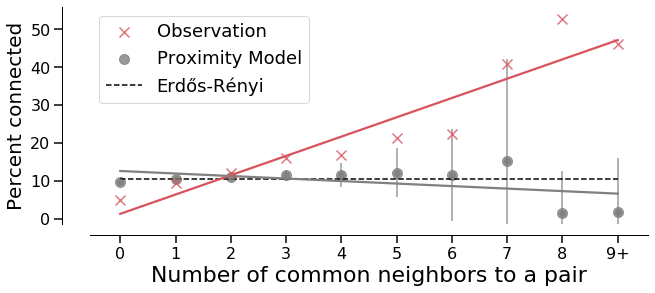

In [17]:
# plot CNR curves
E, N = len(g_th100.edges), len(g_th100.nodes)
ER_p_null = (1 - E / (N*(N-1)))**2

plot_cnr(obs_cnr_stats, pm_cnr_stats, pm_cnr_stats_std, ER_p_null, figsize=(10,4), 
         cfg_name="Proximity Model", fname="th100/proximity_th100_cnr")

In [19]:
# Pearson r^2 and p-value for OBS
pearson_r2(np.arange(10), obs_cnr_stats["undir_perc"])

(0.8793027463711647, 6.106235706259406e-05)

In [20]:
# Pearson r^2 and p-value for CFG
pearson_r2(np.arange(10), pm_cnr_stats["undir_perc"])

(0.2045501930071698, 0.18939789342558672)

### 3. Common Neighbor Rule (OBS vs gER vs PM)

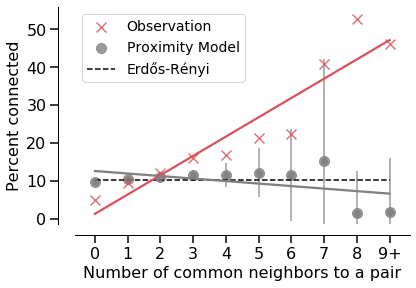

In [21]:
# plot CNR curves
_, two_pr_GE = compute_three_neuron_motif_probabilities_GE(g_th100)
ER_p_null_GE = 1 - 2*two_pr_GE["pr_uni"] - two_pr_GE["pr_bi"]

plot_cnr(obs_cnr_stats, pm_cnr_stats, pm_cnr_stats_std, ER_p_null_GE, 
         figsize=(6,4), fontsizes=(16, 16, 16, 14), cfg_name="Proximity Model",  
         fname="th100/proximity_th100_cnr_GE")

In [22]:
# Pearson r^2 and p-value for OBS
pearson_r2(np.arange(10), obs_cnr_stats["undir_perc"])

(0.8793027463711647, 6.106235706259406e-05)

In [23]:
# Pearson r^2 and p-value for CFG
pearson_r2(np.arange(10), pm_cnr_stats["undir_perc"])

(0.2045501930071698, 0.18939789342558672)